<a href="https://colab.research.google.com/github/WawanByl/Learning-RAG/blob/main/Learning_Retrieval_Augmented_Generation_(RAG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieval Augmented Generation (RAG)

Learn to create a RAG application with a knowledge base in the form of Indonesian independence history texts. Text can be taken from wikipedia. The knowledge base can be updated, either added or replaced.

In [ ]:
!nvidia-smi

Mon Aug  5 14:42:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install torch==2.3.1 PyMuPDF==1.23.26 matplotlib==3.8.3 numpy==1.26.4 pandas==2.2.1 requests==2.31.0 sentence-transformers==2.5.1 tqdm==4.66.2 transformers==4.38.2 spacy accelerate bitsandbytes jupyter wheel flash-attn --no-build-isolation
clear_output()

In [ ]:
!apt-get update
!apt-get install -y build-essential python3-dev cmake
!pip install --upgrade pip setuptools
!pip install flash-attn --no-build-isolation
!pip install git+https://github.com/Dao-AILab/flash-attention.git
clear_output()

In [ ]:
import matplotlib
import numpy
import pandas
import requests
import sentence_transformers
import spacy
import tqdm
import transformers
import accelerate
import bitsandbytes
import jupyter

print("matplotlib version:", matplotlib.__version__)
print("numpy version:", numpy.__version__)
print("pandas version:", pandas.__version__)
print("Requests version:", requests.__version__)
print("sentence_transformers version:", sentence_transformers.__version__)
print("spacy version:", spacy.__version__)
print("tqdm version:", tqdm.__version__)
print("transformers version:", transformers.__version__)
print("accelerate version:", accelerate.__version__)
print("bitsandbytes version:", bitsandbytes.__version__)
print("jupyter version:", jupyter.__version__)

matplotlib version: 3.8.3
numpy version: 1.26.4
pandas version: 2.2.1
Requests version: 2.31.0
sentence_transformers version: 2.5.1
spacy version: 3.7.5
tqdm version: 4.66.2
transformers version: 4.38.2
accelerate version: 0.32.1
bitsandbytes version: 0.43.3
jupyter version: 1.0.0


In [ ]:
# Download PDF file
import os
import requests

# Get PDF document
pdf_path = "/content/drive/MyDrive/Colab Notebooks/Indepence Day.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF you want to download
  url = "https://drive.google.com/file/d/1X7_oE1cKu_zhgjvf4AMEvuT9dm908IAi/view?usp=sharing"

  # The local filename to save the downloaded file
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Open a file in binary write mode and save the content to it
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File /content/drive/MyDrive/Colab Notebooks/Indepence Day.pdf exists.


In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 2420,
  'page_word_count': 413,
  'page_sentence_count_raw': 22,
  'page_token_count': 605.0,
  'text': '**Translation of the Indonesian Independence Proclamation Text into English:** **Indonesian Independence Proclamation** Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed  by Sayuti Melik and was signed by Sukarno-Hatta. The Proclamation House, complete with the Proclamation Monument around the years 1950-1960  on East Pegangsaan Street (now Proclamation Street). The Proclamation House has since been  destroyed, while the Proclamation Monument still stands in the current Proclamation Park. The Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17 August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that Japanese calendar) at 10:00  Japanese time, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan  Street No. 56, Central Jaka

In [ ]:
import random

# Misalkan pages_and_texts adalah list atau koleksi lainnya
print(len(pages_and_texts))  # Mengecek jumlah elemen dalam pages_and_texts

# Pastikan k tidak lebih besar dari jumlah elemen dalam pages_and_texts
k = 2
if len(pages_and_texts) >= k:
    sample = random.sample(pages_and_texts, k=k)
else:
    print(f"Jumlah elemen {len(pages_and_texts)} tidak cukup untuk sampel sebesar {k}")

2


In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,2420,413,22,605.0,**Translation of the Indonesian Independence P...
1,-40,2040,325,11,510.0,The proclamation read from the Pegangsaan Timu...


In [ ]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,2.00,2.0,2.00,2.00,2.00
mean,-40.50,2230.0,369.00,16.50,557.50
std,0.71,268.7,62.23,7.78,67.18
min,-41.00,2040.0,325.00,11.00,510.00
25%,-40.75,2135.0,347.00,13.75,533.75
50%,-40.50,2230.0,369.00,16.50,557.50
75%,-40.25,2325.0,391.00,19.25,581.25
max,-40.00,2420.0,413.00,22.00,605.00


In [ ]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is a sentence., This another sentence.]

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': -41,
  'page_char_count': 2420,
  'page_word_count': 413,
  'page_sentence_count_raw': 22,
  'page_token_count': 605.0,
  'text': '**Translation of the Indonesian Independence Proclamation Text into English:** **Indonesian Independence Proclamation** Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed  by Sayuti Melik and was signed by Sukarno-Hatta. The Proclamation House, complete with the Proclamation Monument around the years 1950-1960  on East Pegangsaan Street (now Proclamation Street). The Proclamation House has since been  destroyed, while the Proclamation Monument still stands in the current Proclamation Park. The Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17 August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that Japanese calendar) at 10:00  Japanese time, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan  Street No. 56, Central Jaka

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,2.00,2.0,2.00,2.00,2.00,2.00
mean,-40.50,2230.0,369.00,16.50,557.50,15.00
std,0.71,268.7,62.23,7.78,67.18,5.66
min,-41.00,2040.0,325.00,11.00,510.00,11.00
25%,-40.75,2135.0,347.00,13.75,533.75,13.00
50%,-40.50,2230.0,369.00,16.50,557.50,15.00
75%,-40.25,2325.0,391.00,19.25,581.25,17.00
max,-40.00,2420.0,413.00,22.00,605.00,19.00


In [ ]:
num_sentence_chunk_size = 10

def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
random.sample(pages_and_texts, k=1)

[{'page_number': -41,
  'page_char_count': 2420,
  'page_word_count': 413,
  'page_sentence_count_raw': 22,
  'page_token_count': 605.0,
  'text': '**Translation of the Indonesian Independence Proclamation Text into English:** **Indonesian Independence Proclamation** Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed  by Sayuti Melik and was signed by Sukarno-Hatta. The Proclamation House, complete with the Proclamation Monument around the years 1950-1960  on East Pegangsaan Street (now Proclamation Street). The Proclamation House has since been  destroyed, while the Proclamation Monument still stands in the current Proclamation Park. The Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17 August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that Japanese calendar) at 10:00  Japanese time, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan  Street No. 56, Central Jaka

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,2.00,2.0,2.00,2.00,2.00,2.00,2.0
mean,-40.50,2230.0,369.00,16.50,557.50,15.00,2.0
std,0.71,268.7,62.23,7.78,67.18,5.66,0.0
min,-41.00,2040.0,325.00,11.00,510.00,11.00,2.0
25%,-40.75,2135.0,347.00,13.75,533.75,13.00,2.0
50%,-40.50,2230.0,369.00,16.50,557.50,15.00,2.0
75%,-40.25,2325.0,391.00,19.25,581.25,17.00,2.0
max,-40.00,2420.0,413.00,22.00,605.00,19.00,2.0


In [ ]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/2 [00:00<?, ?it/s]

4

In [ ]:
random.sample(pages_and_chunks, k=1)

[{'page_number': -41,
  'sentence_chunk': "**Translation of the Indonesian Independence Proclamation Text into English:** **Indonesian Independence Proclamation** Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta. The Proclamation House, complete with the Proclamation Monument around the years 1950-1960 on East Pegangsaan Street (now Proclamation Street). The Proclamation House has since been destroyed, while the Proclamation Monument still stands in the current Proclamation Park. The Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17 August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that Japanese calendar) at 10:00 Japanese time, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No.56, Central Jakarta. Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large 

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,4.00,4.00,4.00,4.00
mean,-40.50,1105.25,175.25,276.31
std,0.58,782.18,119.83,195.54
min,-41.00,65.00,10.00,16.25
25%,-41.00,859.25,149.50,214.81
50%,-40.50,1200.00,197.00,300.00
75%,-40.00,1446.00,222.75,361.50
max,-40.00,1956.00,297.00,489.00


In [ ]:
min_token_length = 30
valid_rows = df[df["chunk_token_count"] <= min_token_length]
num_valid_rows = len(valid_rows)

sample_size = min(5, num_valid_rows)  # Ambil sampel hingga ukuran minimum antara 5 dan jumlah baris yang tersedia

for _, row in valid_rows.sample(sample_size).iterrows():
    print(f'Chunk token count: {row["chunk_token_count"]} | Text: {row["sentence_chunk"]}')

Chunk token count: 16.25 | Text: This moment was seized by Indonesia to proclaim its independence.


In [ ]:
valid_rows = df[df["chunk_token_count"] <= min_token_length]
num_valid_rows = len(valid_rows)
print(f'Jumlah baris yang valid: {num_valid_rows}')

Jumlah baris yang valid: 1


In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': "**Translation of the Indonesian Independence Proclamation Text into English:** **Indonesian Independence Proclamation** Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta. The Proclamation House, complete with the Proclamation Monument around the years 1950-1960 on East Pegangsaan Street (now Proclamation Street). The Proclamation House has since been destroyed, while the Proclamation Monument still stands in the current Proclamation Park. The Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17 August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that Japanese calendar) at 10:00 Japanese time, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No.56, Central Jakarta. Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large 

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981188e-02  3.03164795e-02 -2.01218072e-02  6.86483085e-02
 -2.55255401e-02 -8.47692974e-03 -2.07088728e-04 -6.32377863e-02
  2.81606447e-02 -3.33353542e-02  3.02634742e-02  5.30720390e-02
 -5.03526330e-02  2.62288321e-02  3.33313867e-02 -4.51578684e-02
  3.63044105e-02 -1.37114769e-03 -1.20171010e-02  1.14946850e-02
  5.04510738e-02  4.70857024e-02  2.11913269e-02  5.14607392e-02
 -2.03746352e-02 -3.58889922e-02 -6.67880289e-04 -2.94393245e-02
  4.95858602e-02 -1.05640031e-02 -1.52013926e-02 -1.31751515e-03
  4.48197126e-02  1.56023093e-02  8.60379714e-07 -1.21392251e-03
 -2.37978455e-02 -9.09413560e-04  7.34486757e-03 -2.53935461e-03
  5.23370281e-02 -4.68043573e-02  1.66214760e-02  4.71579768e-02
 -4.15599681e-02  9.01928695e-04  3.60278450e-02  3.42215225e-02
  9.68227163e-02  5.94829172e-02 -1.64984949e-02 -3.51249948e-02
  5.92521718e-03 -7.07982690e-04 -2.4103

In [ ]:
single_sentence = "Hello world"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Hello world
Embedding:
[ 2.62496658e-02  1.33956326e-02 -4.53315815e-03 -2.17914023e-02
  5.45518436e-02 -4.96649882e-03  6.65562507e-03  3.06262448e-02
 -5.76289743e-03 -4.56202915e-03 -3.31327692e-03 -4.84962352e-02
 -1.13640567e-02  3.50774601e-02  9.30946320e-02 -8.66873786e-02
  5.10865264e-02  9.88616515e-03 -6.35692701e-02 -8.55020061e-03
  7.05442484e-03 -3.86242452e-03  2.47443113e-02  4.28849421e-02
  3.50941718e-02 -2.98482254e-02  1.02525922e-02  2.23449282e-02
  2.08899602e-02  9.49218776e-03 -3.30443420e-02 -1.22841336e-02
  5.35289049e-02  2.54291948e-02  2.02217689e-06 -3.41910012e-02
  9.61000007e-03 -1.64845064e-02  5.60953142e-03 -4.25006729e-03
 -2.28011999e-02  4.03547399e-02  3.05201416e-03  3.13726328e-02
 -1.08124027e-02 -3.55708301e-02  2.22928636e-02  1.68718386e-03
  2.07723677e-03  2.31162403e-02  6.88585499e-03 -6.83092186e-03
 -4.87613194e-02 -2.70107891e-02  1.54911000e-02  3.73169705e-02
  2.72793453e-02  2.64989603e-02 -1.69228995e-03 -2.88223

In [ ]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1 s, sys: 117 ms, total: 1.12 s
Wall time: 1.36 s


In [ ]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)
text_chunk_embeddings

CPU times: user 68.1 ms, sys: 1.69 ms, total: 69.8 ms
Wall time: 44 ms


tensor([[ 0.0698,  0.0060,  0.0122,  ...,  0.0151, -0.0145,  0.0502],
        [ 0.0131, -0.0130,  0.0044,  ...,  0.0330, -0.0380,  0.0537],
        [ 0.0551,  0.0403,  0.0017,  ..., -0.0067,  0.0100,  0.0498]],
       device='cuda:0')

In [ ]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,**Translation of the Indonesian Independence P...,1276,196,319.0,[ 6.98440149e-02 6.04623463e-03 1.22442311e-...
1,-41,"P. R. Feith as mentioned by Kwee Kek Beng, edi...",1124,198,281.0,[ 1.31011577e-02 -1.30375214e-02 4.37747873e-...
2,-40,The proclamation read from the Pegangsaan Timu...,1956,297,489.0,[ 5.51012494e-02 4.03343514e-02 1.73046545e-...


In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("/content/text_chunks_and_embeddings_df.csv")

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([3, 768])

In [ ]:
print(text_chunks_and_embedding_df.columns)

Index(['page_number', 'sentence_chunk', 'chunk_char_count', 'chunk_word_count',
       'chunk_token_count', 'embedding'],
      dtype='object')


In [ ]:
print(text_chunks_and_embedding_df.head())

   page_number                                     sentence_chunk  \
0          -41  **Translation of the Indonesian Independence P...   
1          -41  P. R. Feith as mentioned by Kwee Kek Beng, edi...   
2          -40  The proclamation read from the Pegangsaan Timu...   

   chunk_char_count  chunk_word_count  chunk_token_count  \
0              1276               196              319.0   
1              1124               198              281.0   
2              1956               297              489.0   

                                           embedding  
0  [0.0698440149, 0.00604623463, 0.0122442311, -0...  
1  [0.0131011577, -0.0130375214, 0.00437747873, 0...  
2  [0.0551012494, 0.0403343514, 0.00173046545, -0...  


In [ ]:
embeddings[0]

tensor([ 6.9844e-02,  6.0462e-03,  1.2244e-02, -1.2397e-02, -2.5000e-02,
         1.9192e-02, -4.0791e-02,  3.3067e-02,  2.4792e-03,  2.3629e-02,
        -1.4654e-02,  2.0058e-02,  2.9337e-02, -5.6785e-02, -1.0998e-02,
        -5.1979e-02,  5.0189e-02,  4.5761e-03,  9.3766e-02, -2.8015e-02,
        -3.7020e-02,  1.3314e-02,  2.6197e-02,  3.0229e-02, -3.9451e-02,
        -2.2042e-02, -4.0541e-02, -5.3572e-02, -6.5980e-02, -2.3484e-02,
         3.5665e-02,  1.3639e-02, -4.5230e-03, -1.7177e-03,  2.2503e-06,
         9.9352e-03,  3.0155e-02,  2.3317e-02, -1.6075e-03,  1.9080e-02,
        -1.3173e-02, -3.1460e-02, -3.6671e-02, -1.7942e-02, -4.7428e-02,
        -9.7438e-02,  1.9817e-02,  5.6691e-02,  1.5440e-02,  2.4489e-02,
        -4.5676e-03, -8.5265e-02,  6.4511e-03, -2.7697e-02, -1.0103e-02,
         2.0982e-02, -2.3703e-02, -6.7193e-02, -7.1344e-02,  1.6683e-02,
         2.3195e-03,  2.5995e-04, -2.3732e-02, -3.9929e-05, -2.7674e-02,
        -8.4017e-02,  1.8484e-02, -4.8018e-02,  4.1

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
query = "The Proclamation House"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_results_dot_product = torch.topk(dot_scores, k=2)
top_results_dot_product

Query: The Proclamation House
Time take to get scores on 3 embeddings: 0.00410 seconds.


torch.return_types.topk(
values=tensor([0.4294, 0.2744], device='cuda:0'),
indices=tensor([0, 2], device='cuda:0'))

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([300, 768])
Time take to get scores on 300 embeddings: 0.00076 seconds.


In [ ]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [ ]:
print(f"Query: '{query}'\n")
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'The Proclamation House'

Results:
Score: 0.4294
Text:
**Translation of the Indonesian Independence Proclamation Text into English:**
**Indonesian Independence Proclamation** Sukarno read the Proclamation of
Independence of the Republic of Indonesia, which had been typed by Sayuti Melik
and was signed by Sukarno-Hatta. The Proclamation House, complete with the
Proclamation Monument around the years 1950-1960 on East Pegangsaan Street (now
Proclamation Street). The Proclamation House has since been destroyed, while the
Proclamation Monument still stands in the current Proclamation Park. The
Indonesian Independence Proclamation took place on Friday, 17 August 1945, or 17
August 2605 according to the Japanese year (kōki) (17 August Shōwa 20 in that
Japanese calendar) at 10:00 Japanese time, read by Sukarno accompanied by
Mohammad Hatta at a house on East Pegangsaan Street No.56, Central Jakarta.
Chairul Basri, who worked at the Japanese propaganda office, was tasked with
finding a 

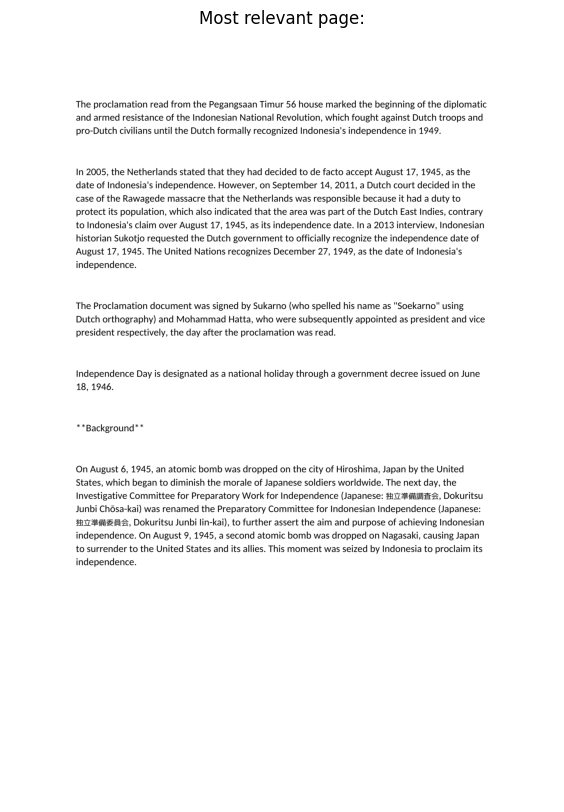

In [ ]:
import fitz
import numpy as np
import matplotlib.pyplot as plt

# Path ke file PDF
pdf_path = "/content/drive/MyDrive/Colab Notebooks/Indepence Day.pdf"

# Buka PDF dan load halaman yang diinginkan
doc = fitz.open(pdf_path)

# Halaman dimulai dari 0, jadi halaman kedua adalah index 1
page_number = 1  # Jika halaman pertama adalah 0, halaman kedua adalah 1
page = doc.load_page(page_number)

# Dapatkan gambar halaman
img = page.get_pixmap(dpi=300)

# Tutup dokumen PDF
doc.close()

# Konversi Pixmap ke numpy array
img_array = np.frombuffer(img.samples, dtype=np.uint8).reshape((img.h, img.w, img.n))

# Tampilkan gambar menggunakan Matplotlib
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Most relevant page:")
plt.axis('off')  # Matikan axis
plt.show()

In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [ ]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")

    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

documents = [
    "Ini adalah dokumen pertama.",
    "Ini adalah dokumen kedua.",
    "Ini adalah dokumen ketiga."
]

# Menghasilkan embedding untuk dokumen
embeddings = model.encode(documents, convert_to_tensor=True)

# Query yang ingin dicari
query = "pegangsaan"

# Fungsi untuk mendapatkan sumber daya yang relevan
def retrieve_relevant_resources(query, embeddings, model=model, n_resources_to_return=5, print_time=False):
    import time
    query_embedding = model.encode(query, convert_to_tensor=True)

    if print_time:
        start_time = time.time()

    # Hitung kesamaan kosinus
    dot_scores = util.pytorch_cos_sim(query_embedding, embeddings)[0]

    if print_time:
        end_time = time.time()
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    # Pastikan k tidak lebih besar dari jumlah elemen dalam dot_scores
    n_resources_to_return = min(n_resources_to_return, len(dot_scores))

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores.cpu().numpy(), indices.cpu().numpy()

# Mendapatkan skor dan indeks dari hasil yang paling relevan
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

# Menampilkan skor dan indeks
print("Scores:", scores)
print("Indices:", indices)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Scores: [0.46442252 0.45968804 0.2918239 ]
Indices: [1 2 0]


In [ ]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Query: pegangsaan

Results:
Score: 0.4644
P. R. Feith as mentioned by Kwee Kek Beng, editor-in-chief of the Sin Po
newspaper from 1925 to 1947, in Doea Poeloe Lima Tahon Sebagi Wartawan,
1922–1947 (1948). From a news article in Sin Po on July 5, 1948, it is known
that the house was a historic site for the Indonesian nation because it was the
place where independence was proclaimed. The house had also been used as a
meeting house. The Dutch had also used the house as a prison house. The house
then changed again into the Republic Building. Eventually, its Dutch owner sold
it for 250,000 guilders (ƒ). The house was eventually bought by the Indonesian
government. Here is how the news report read: "The owner of the house that had
just returned from the Netherlands has decided to sell his property for ƒ
250,000,- to the Republic government" From here, no evidence has been found
linking the purchase of the house by the Republic of Indonesia government in
1948 with the information about the do

In [ ]:
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 40 GB


In [ ]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 40 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]


In [ ]:
from IPython.display import clear_output
!pip install scipy<1.14.0,>=1.7.0
!pip install pytest==8.3.1
!pip install einops==0.8.0
!pip install lion-pytorch==0.2.2
clear_output()

In [ ]:
from huggingface_hub import login

# Ganti 'your_token_here' dengan token API yang Anda dapatkan dari Hugging Face
login(token="r4Ha5ia", add_to_git_credential=True)

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

print("[INFO] Model loaded and ready for inference.")

[INFO] Using attention implementation: flash_attention_2
[INFO] Using model_id: google/gemma-7b-it


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

[INFO] Model loaded and ready for inference.


In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaFlashAttention2(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gem

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

In [ ]:
def get_model_mem_size(model: torch.nn.Module):

    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17142470656,
 'model_mem_mb': 16348.33,
 'model_mem_gb': 15.97}

In [ ]:
input_text = "Tell me about the house pegangsaan?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Tell me about the house pegangsaan?

Prompt (formatted):
<bos><start_of_turn>user
Tell me about the house pegangsaan?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,  27445,    682,   1105,    573,
           3036,   1099,   9643, 105962, 235336,    107,    108,    106,   2516,
            108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,  27445,    682,   1105,    573,
          3036,   1099,   9643, 105962, 235336,    107,    108,    106,   2516,
           108,    651,   4919,    576,   3742,   9643, 105962,    603,    476,
         13457,   3036,   7023,    575, 122809, 235269,  14000, 235265,   1165,
           603,    476,   9121, 207155,   3000,   3036,   6233,    575,    573,
        235248, 235274, 235321,    489,   7861, 235269,    578,    603,   3836,
           604,   1277,   6239,  16333,    578,   7277,   4281, 235265,    109,
           688,  64335,  66058,    109, 235287,   5231,  27300,  11

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
Tell me about the house pegangsaan?<end_of_turn>
<start_of_turn>model
The House of Pegangsaan is a historical house located in Yogyakarta, Indonesia. It is a traditional Javanese house built in the 18th century, and is known for its unique architecture and rich history.

**Architecture:**

* **Unique roof:** The house has a distinctive roof made of interlocking tiles that resemble a fan.
* **Open layout:** The main living area is open-plan, with a central courtyard that serves as the heart of the house.
* **Traditional materials:** The house is constructed using traditional Javanese materials such as wood, stone, and bamboo.
* **Intricate carvings:** The walls and pillars are adorned with intricate carvings that depict mythological stories and religious symbols.

**History:**

* **18th century:** The house was built in the 18th century by a wealthy merchant named Pegangsaan.
* **Royal patronage:** The house was once owned by a numbe

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Tell me about the house pegangsaan?

Output text:
The House of Pegangsaan is a historical house located in Yogyakarta, Indonesia. It is a traditional Javanese house built in the 18th century, and is known for its unique architecture and rich history.

**Architecture:**

* **Unique roof:** The house has a distinctive roof made of interlocking tiles that resemble a fan.
* **Open layout:** The main living area is open-plan, with a central courtyard that serves as the heart of the house.
* **Traditional materials:** The house is constructed using traditional Javanese materials such as wood, stone, and bamboo.
* **Intricate carvings:** The walls and pillars are adorned with intricate carvings that depict mythological stories and religious symbols.

**History:**

* **18th century:** The house was built in the 18th century by a wealthy merchant named Pegangsaan.
* **Royal patronage:** The house was once owned by a number of Indonesian royalty, including the Sultan of Yogyakarta.
*

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

documents = [
    "Sukarno is the first President of Indonesia.",
    "Chairul is a common name in Indonesia.",
    "The house is located in Jakarta.",
    "The owner of the house is Mr. X.",
    "Indonesia gained its independence on August 17, 1945."
]

embeddings = np.random.rand(len(documents), 5)

def retrieve_relevant_resources(query, embeddings, documents, top_n=3):

    query_embedding = np.random.rand(1, 5)

    similarities = cosine_similarity(query_embedding, embeddings)[0]

    top_indices = similarities.argsort()[-top_n:][::-1]
    top_scores = similarities[top_indices]

    return top_scores, top_indices

gpt4_questions = [
    "Who is Sukarno?",
    "Who is Chairul?",
    "Where is the house?"
]

manual_questions = [
    "Who is the house owner?",
    "When is Indonesia's independence?"
]

query_list = gpt4_questions + manual_questions

import random
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                              documents=documents)
print("Scores:", scores)
print("Indices:", indices)
print("Top related documents:")
for idx in indices:
    print(documents[idx])

Query: Where is the house?
Scores: [0.90923194 0.88555444 0.83946577]
Indices: [3 1 2]
Top related documents:
The owner of the house is Mr. X.
Chairul is a common name in Indonesia.
The house is located in Jakarta.


In [ ]:
gpt4_questions = [
    "Who is Sukarno?",
    "Who is Chairul?",
    "Where is the house?"
]

manual_questions = [
    "Who is the house owner?",
    "When Indonesia's independence?"
]

query_list = gpt4_questions + manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                              documents=documents)
scores, indices

Query: Who is Sukarno?


(array([0.93401871, 0.90625568, 0.86230576]), array([1, 3, 2]))

In [ ]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

documents = [
    "Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta.",
    "The Indonesian Independence Proclamation took place on Friday, 17 August 1945, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No. 56, Central Jakarta.",
    "Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large yard. The Pegangsaan Timur 56 house owned by a Dutch person was exchanged for another house on Lembang Street."
]

embeddings = np.random.rand(len(documents), 5)

def retrieve_relevant_resources(query, embeddings, documents, top_n=3):
    query_embedding = np.random.rand(1, 5)

    similarities = cosine_similarity(query_embedding, embeddings)[0]

    top_indices = similarities.argsort()[-top_n:][::-1]
    top_scores = similarities[top_indices]

    return top_scores, top_indices

def prompt_formatter(query: str, context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: Who is Sukarno?
Answer: Sukarno is the first president of Indonesia. He was born on June 6, 1901, and was one of the main figures in the Indonesian independence movement. Sukarno proclaimed Indonesia's independence on August 17, 1945, and served as president from 1945 to 1967.
\nExample 2:
Query: What is the Indonesian Independence Proclamation?
Answer: The Indonesian Independence Proclamation is the declaration of Indonesia's independence from Dutch and Japanese colonial rule, which was read by Sukarno on August 17, 1945. The proclamation text was written by Sukarno and Mohammad Hatta, and was read at Pegangsaan Timur 56, Jakarta.
\nExample 3:
Query: How did Indonesia gain its independence?
Answer: Indonesia's independence involved both diplomatic and armed struggles against Dutch colonial forces. Following the proclamation on August 17, 1945, various battles and negotiations took place until the Dutch officially recognized Indonesia's independence on December 27, 1949. In 2005, the Netherlands acknowledged August 17, 1945, as Indonesia's de facto independence day.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    base_prompt = base_prompt.format(context=context, query=query)

    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    return prompt

# Example pages_and_chunks (simulated for demonstration purposes)
pages_and_chunks = [
    {"sentence_chunk": "Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta."},
    {"sentence_chunk": "The Indonesian Independence Proclamation took place on Friday, 17 August 1945, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No. 56, Central Jakarta."},
    {"sentence_chunk": "Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large yard. The Pegangsaan Timur 56 house owned by a Dutch person was exchanged for another house on Lembang Street."}
]

# Generate the query list
gpt4_questions = [
    "Who is Sukarno?",
    "Who is Chairul?",
    "Where is the house?"
]

manual_questions = [
    "Who is the house owner?",
    "When is Indonesia's independence?"
]

query_list = gpt4_questions + manual_questions

query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                              documents=documents)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Who is Chairul?
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: Who is Sukarno?
Answer: Sukarno is the first president of Indonesia. He was born on June 6, 1901, and was one of the main figures in the Indonesian independence movement. Sukarno proclaimed Indonesia's independence on August 17, 1945, and served as president from 1945 to 1967.

Example 2:
Query: What is the Indonesian Independence Proclamation?
Answer: The Indonesian Independence Proclamation is the declaration of Indonesia's independence from Dutch and Japanese colonial rule, which was read by Sukarno on August 17, 1945. The proclamation text was written by Sukarno and Mohammad Hatta

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                             max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Who is Chairul?
RAG answer:
<bos>**Relevant passages:**

There is no text about Chairul in the provided text, therefore I cannot extract the requested data.<eos>
CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  documents=documents)

    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text

    return output_text, context_items

In [ ]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

documents = [
    "Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta.",
    "The Indonesian Independence Proclamation took place on Friday, 17 August 1945, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No. 56, Central Jakarta.",
    "Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large yard. The Pegangsaan Timur 56 house owned by a Dutch person was exchanged for another house on Lembang Street."
]

embeddings = np.random.rand(len(documents), 5)

def retrieve_relevant_resources(query, embeddings, documents, top_n=3):
    query_embedding = np.random.rand(1, 5)

    similarities = cosine_similarity(query_embedding, embeddings)[0]

    top_indices = similarities.argsort()[-top_n:][::-1]
    top_scores = similarities[top_indices]

    return top_scores, top_indices

def prompt_formatter(query: str, context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: Who is Sukarno?
Answer: Sukarno is the first president of Indonesia. He was born on June 6, 1901, and was one of the main figures in the Indonesian independence movement. Sukarno proclaimed Indonesia's independence on August 17, 1945, and served as president from 1945 to 1967.
\nExample 2:
Query: What is the Indonesian Independence Proclamation?
Answer: The Indonesian Independence Proclamation is the declaration of Indonesia's independence from Dutch and Japanese colonial rule, which was read by Sukarno on August 17, 1945. The proclamation text was written by Sukarno and Mohammad Hatta, and was read at Pegangsaan Timur 56, Jakarta.
\nExample 3:
Query: How did Indonesia gain its independence?
Answer: Indonesia's independence involved both diplomatic and armed struggles against Dutch colonial forces. Following the proclamation on August 17, 1945, various battles and negotiations took place until the Dutch officially recognized Indonesia's independence on December 27, 1949. In 2005, the Netherlands acknowledged August 17, 1945, as Indonesia's de facto independence day.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    base_prompt = base_prompt.format(context=context, query=query)

    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    return prompt

def ask(query, temperature=0.7, max_new_tokens=512, return_answer_only=True):
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  documents=documents)

    context_items = [{"sentence_chunk": documents[i]} for i in indices]

    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    answer = "Simulated answer based on the context and query."

    if return_answer_only:
        return answer
    else:
        return answer, context_items

gpt4_questions = [
    "Who is Sukarno?",
    "Who is Chairul?",
    "Where is the house?"
]

manual_questions = [
    "Who is the house owner?",
    "When is Indonesia's independence?"
]

query_list = gpt4_questions + manual_questions

query = random.choice(query_list)
print(f"Query: {query}")

answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n{answer}")
print(f"Context items:")
for item in context_items:
    print(item)

Query: When is Indonesia's independence?
Answer:
Simulated answer based on the context and query.
Context items:
{'sentence_chunk': 'Chairul Basri, who worked at the Japanese propaganda office, was tasked with finding a house with a large yard. The Pegangsaan Timur 56 house owned by a Dutch person was exchanged for another house on Lembang Street.'}
{'sentence_chunk': 'The Indonesian Independence Proclamation took place on Friday, 17 August 1945, read by Sukarno accompanied by Mohammad Hatta at a house on East Pegangsaan Street No. 56, Central Jakarta.'}
{'sentence_chunk': 'Sukarno read the Proclamation of Independence of the Republic of Indonesia, which had been typed by Sayuti Melik and was signed by Sukarno-Hatta.'}
